# 05. Memory Dataset

Using the generator is extremely slow.

In [1]:
import pandas as pd
import numpy as np

import logging
import gc

from tqdm.notebook import tqdm
from pqdm.threads import pqdm
from typing import Tuple
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from keras import optimizers
from keras import callbacks

import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb

2023-02-26 15:58:00.735907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 15:58:01.610720: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-26 15:58:01.614134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/current/lib/native:/opt/hadoop/current/lib/native
2023-02-26 15:58:01.6

## Load Source Data

In [2]:
# load the source training set
df_source = pd.read_csv('data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [3]:
# load the source training labels
df_source_labels = pd.read_csv('data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Pre-process Data

### Pre-defined Values

In [4]:
vector_columns = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'event_name_checkpoint', 'event_name_cutscene_click', 'event_name_map_click', 'event_name_map_hover', 'event_name_navigate_click', 'event_name_notebook_click', 'event_name_notification_click', 'event_name_object_click', 'event_name_object_hover', 'event_name_observation_click', 'event_name_person_click', 'name_basic', 'name_close', 'name_next', 'name_open', 'name_prev', 'name_undefined', 'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7', 'level_8', 'level_9', 'level_10', 'level_11', 'level_12', 'level_13', 'level_14', 'level_15', 'level_16', 'level_17', 'level_18', 'level_19', 'level_20', 'level_21', 'level_22', 'fqid_0', 'fqid_archivist', 'fqid_archivist_glasses', 'fqid_block', 'fqid_block_0', 'fqid_block_1', 'fqid_block_badge', 'fqid_block_badge_2', 'fqid_block_magnify', 'fqid_block_nelson', 'fqid_block_tocollection', 'fqid_block_tomap1', 'fqid_block_tomap2', 'fqid_boss', 'fqid_businesscards', 'fqid_businesscards.card_0.next', 'fqid_businesscards.card_1.next', 'fqid_businesscards.card_bingo.bingo', 'fqid_businesscards.card_bingo.next', 'fqid_ch3start', 'fqid_chap1_finale', 'fqid_chap1_finale_c', 'fqid_chap2_finale_c', 'fqid_chap4_finale_c', 'fqid_coffee', 'fqid_colorbook', 'fqid_confrontation', 'fqid_crane_ranger', 'fqid_cs', 'fqid_directory', 'fqid_directory.closeup.archivist', 'fqid_door_block_clean', 'fqid_door_block_talk', 'fqid_doorblock', 'fqid_expert', 'fqid_flag_girl', 'fqid_fox', 'fqid_glasses', 'fqid_gramps', 'fqid_groupconvo', 'fqid_groupconvo_flag', 'fqid_intro', 'fqid_janitor', 'fqid_journals', 'fqid_journals.hub.topics', 'fqid_journals.pic_0.next', 'fqid_journals.pic_1.next', 'fqid_journals.pic_2.bingo', 'fqid_journals.pic_2.next', 'fqid_journals_flag', 'fqid_journals_flag.hub.topics', 'fqid_journals_flag.hub.topics_old', 'fqid_journals_flag.pic_0.bingo', 'fqid_journals_flag.pic_0.next', 'fqid_journals_flag.pic_0_old.next', 'fqid_journals_flag.pic_1.bingo', 'fqid_journals_flag.pic_1.next', 'fqid_journals_flag.pic_1_old.next', 'fqid_journals_flag.pic_2.bingo', 'fqid_journals_flag.pic_2.next', 'fqid_journals_flag.pic_2_old.next', 'fqid_key', 'fqid_lockeddoor', 'fqid_logbook', 'fqid_logbook.page.bingo', 'fqid_magnify', 'fqid_need_glasses', 'fqid_notebook', 'fqid_outtolunch', 'fqid_photo', 'fqid_plaque', 'fqid_plaque.face.date', 'fqid_reader', 'fqid_reader.paper0.next', 'fqid_reader.paper0.prev', 'fqid_reader.paper1.next', 'fqid_reader.paper1.prev', 'fqid_reader.paper2.bingo', 'fqid_reader.paper2.next', 'fqid_reader.paper2.prev', 'fqid_reader_flag', 'fqid_reader_flag.paper0.next', 'fqid_reader_flag.paper0.prev', 'fqid_reader_flag.paper1.next', 'fqid_reader_flag.paper1.prev', 'fqid_reader_flag.paper2.bingo', 'fqid_reader_flag.paper2.next', 'fqid_reader_flag.paper2.prev', 'fqid_remove_cup', 'fqid_report', 'fqid_retirement_letter', 'fqid_savedteddy', 'fqid_seescratches', 'fqid_teddy', 'fqid_tobasement', 'fqid_tocage', 'fqid_tocloset', 'fqid_tocloset_dirty', 'fqid_tocollection', 'fqid_tocollectionflag', 'fqid_toentry', 'fqid_tofrontdesk', 'fqid_togrampa', 'fqid_tohallway', 'fqid_tomap', 'fqid_tomicrofiche', 'fqid_tostacks', 'fqid_tracks', 'fqid_tracks.hub.deer', 'fqid_trigger_coffee', 'fqid_trigger_scarf', 'fqid_tunic', 'fqid_tunic.capitol_0', 'fqid_tunic.capitol_1', 'fqid_tunic.capitol_2', 'fqid_tunic.drycleaner', 'fqid_tunic.flaghouse', 'fqid_tunic.historicalsociety', 'fqid_tunic.hub.slip', 'fqid_tunic.humanecology', 'fqid_tunic.kohlcenter', 'fqid_tunic.library', 'fqid_tunic.wildlife', 'fqid_unlockdoor', 'fqid_wells', 'fqid_wellsbadge', 'fqid_what_happened', 'fqid_worker', 'room_fqid_tunic.capitol_0.hall', 'room_fqid_tunic.capitol_1.hall', 'room_fqid_tunic.capitol_2.hall', 'room_fqid_tunic.drycleaner.frontdesk', 'room_fqid_tunic.flaghouse.entry', 'room_fqid_tunic.historicalsociety.basement', 'room_fqid_tunic.historicalsociety.cage', 'room_fqid_tunic.historicalsociety.closet', 'room_fqid_tunic.historicalsociety.closet_dirty', 'room_fqid_tunic.historicalsociety.collection', 'room_fqid_tunic.historicalsociety.collection_flag', 'room_fqid_tunic.historicalsociety.entry', 'room_fqid_tunic.historicalsociety.frontdesk', 'room_fqid_tunic.historicalsociety.stacks', 'room_fqid_tunic.humanecology.frontdesk', 'room_fqid_tunic.kohlcenter.halloffame', 'room_fqid_tunic.library.frontdesk', 'room_fqid_tunic.library.microfiche', 'room_fqid_tunic.wildlife.center', 'text_fqid_0', 'text_fqid_tunic.capitol_0.hall.boss.talktogramps', 'text_fqid_tunic.capitol_0.hall.chap1_finale_c', 'text_fqid_tunic.capitol_1.hall.boss.haveyougotit', 'text_fqid_tunic.capitol_1.hall.boss.writeitup', 'text_fqid_tunic.capitol_1.hall.chap2_finale_c', 'text_fqid_tunic.capitol_2.hall.boss.haveyougotit', 'text_fqid_tunic.capitol_2.hall.chap4_finale_c', 'text_fqid_tunic.drycleaner.frontdesk.block_0', 'text_fqid_tunic.drycleaner.frontdesk.block_1', 'text_fqid_tunic.drycleaner.frontdesk.logbook.page.bingo', 'text_fqid_tunic.drycleaner.frontdesk.worker.done', 'text_fqid_tunic.drycleaner.frontdesk.worker.done2', 'text_fqid_tunic.drycleaner.frontdesk.worker.hub', 'text_fqid_tunic.drycleaner.frontdesk.worker.takealook', 'text_fqid_tunic.flaghouse.entry.colorbook', 'text_fqid_tunic.flaghouse.entry.flag_girl.hello', 'text_fqid_tunic.flaghouse.entry.flag_girl.hello_recap', 'text_fqid_tunic.flaghouse.entry.flag_girl.symbol', 'text_fqid_tunic.flaghouse.entry.flag_girl.symbol_recap', 'text_fqid_tunic.historicalsociety.basement.ch3start', 'text_fqid_tunic.historicalsociety.basement.gramps.seeyalater', 'text_fqid_tunic.historicalsociety.basement.gramps.whatdo', 'text_fqid_tunic.historicalsociety.basement.janitor', 'text_fqid_tunic.historicalsociety.basement.savedteddy', 'text_fqid_tunic.historicalsociety.basement.seescratches', 'text_fqid_tunic.historicalsociety.cage.confrontation', 'text_fqid_tunic.historicalsociety.cage.glasses.afterteddy', 'text_fqid_tunic.historicalsociety.cage.glasses.beforeteddy', 'text_fqid_tunic.historicalsociety.cage.lockeddoor', 'text_fqid_tunic.historicalsociety.cage.need_glasses', 'text_fqid_tunic.historicalsociety.cage.teddy.trapped', 'text_fqid_tunic.historicalsociety.cage.unlockdoor', 'text_fqid_tunic.historicalsociety.closet.doorblock', 'text_fqid_tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'text_fqid_tunic.historicalsociety.closet.intro', 'text_fqid_tunic.historicalsociety.closet.notebook', 'text_fqid_tunic.historicalsociety.closet.photo', 'text_fqid_tunic.historicalsociety.closet.retirement_letter.hub', 'text_fqid_tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'text_fqid_tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'text_fqid_tunic.historicalsociety.closet_dirty.door_block_clean', 'text_fqid_tunic.historicalsociety.closet_dirty.door_block_talk', 'text_fqid_tunic.historicalsociety.closet_dirty.gramps.archivist', 'text_fqid_tunic.historicalsociety.closet_dirty.gramps.helpclean', 'text_fqid_tunic.historicalsociety.closet_dirty.gramps.news', 'text_fqid_tunic.historicalsociety.closet_dirty.gramps.nothing', 'text_fqid_tunic.historicalsociety.closet_dirty.photo', 'text_fqid_tunic.historicalsociety.closet_dirty.trigger_coffee', 'text_fqid_tunic.historicalsociety.closet_dirty.trigger_scarf', 'text_fqid_tunic.historicalsociety.closet_dirty.what_happened', 'text_fqid_tunic.historicalsociety.collection.cs', 'text_fqid_tunic.historicalsociety.collection.gramps.found', 'text_fqid_tunic.historicalsociety.collection.gramps.look_0', 'text_fqid_tunic.historicalsociety.collection.gramps.lost', 'text_fqid_tunic.historicalsociety.collection.tunic', 'text_fqid_tunic.historicalsociety.collection.tunic.slip', 'text_fqid_tunic.historicalsociety.collection_flag.gramps.flag', 'text_fqid_tunic.historicalsociety.collection_flag.gramps.recap', 'text_fqid_tunic.historicalsociety.entry.block_tocollection', 'text_fqid_tunic.historicalsociety.entry.block_tomap1', 'text_fqid_tunic.historicalsociety.entry.block_tomap2', 'text_fqid_tunic.historicalsociety.entry.boss.flag', 'text_fqid_tunic.historicalsociety.entry.boss.flag_recap', 'text_fqid_tunic.historicalsociety.entry.boss.talktogramps', 'text_fqid_tunic.historicalsociety.entry.directory.closeup.archivist', 'text_fqid_tunic.historicalsociety.entry.gramps.hub', 'text_fqid_tunic.historicalsociety.entry.groupconvo', 'text_fqid_tunic.historicalsociety.entry.groupconvo_flag', 'text_fqid_tunic.historicalsociety.entry.wells.flag', 'text_fqid_tunic.historicalsociety.entry.wells.flag_recap', 'text_fqid_tunic.historicalsociety.entry.wells.talktogramps', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.have_glass', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.hello', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.newspaper', 'text_fqid_tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'text_fqid_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'text_fqid_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'text_fqid_tunic.historicalsociety.frontdesk.block_magnify', 'text_fqid_tunic.historicalsociety.frontdesk.key', 'text_fqid_tunic.historicalsociety.frontdesk.magnify', 'text_fqid_tunic.historicalsociety.stacks.block', 'text_fqid_tunic.historicalsociety.stacks.journals.pic_2.bingo', 'text_fqid_tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'text_fqid_tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'text_fqid_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'text_fqid_tunic.historicalsociety.stacks.outtolunch', 'text_fqid_tunic.humanecology.frontdesk.block_0', 'text_fqid_tunic.humanecology.frontdesk.block_1', 'text_fqid_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'text_fqid_tunic.humanecology.frontdesk.worker.badger', 'text_fqid_tunic.humanecology.frontdesk.worker.intro', 'text_fqid_tunic.kohlcenter.halloffame.block_0', 'text_fqid_tunic.kohlcenter.halloffame.plaque.face.date', 'text_fqid_tunic.kohlcenter.halloffame.togrampa', 'text_fqid_tunic.library.frontdesk.block_badge', 'text_fqid_tunic.library.frontdesk.block_badge_2', 'text_fqid_tunic.library.frontdesk.block_nelson', 'text_fqid_tunic.library.frontdesk.wellsbadge.hub', 'text_fqid_tunic.library.frontdesk.worker.droppedbadge', 'text_fqid_tunic.library.frontdesk.worker.flag', 'text_fqid_tunic.library.frontdesk.worker.flag_recap', 'text_fqid_tunic.library.frontdesk.worker.hello', 'text_fqid_tunic.library.frontdesk.worker.hello_short', 'text_fqid_tunic.library.frontdesk.worker.nelson', 'text_fqid_tunic.library.frontdesk.worker.nelson_recap', 'text_fqid_tunic.library.frontdesk.worker.preflag', 'text_fqid_tunic.library.frontdesk.worker.wells', 'text_fqid_tunic.library.frontdesk.worker.wells_recap', 'text_fqid_tunic.library.microfiche.block_0', 'text_fqid_tunic.library.microfiche.reader.paper2.bingo', 'text_fqid_tunic.library.microfiche.reader_flag.paper2.bingo', 'text_fqid_tunic.wildlife.center.coffee', 'text_fqid_tunic.wildlife.center.crane_ranger.crane', 'text_fqid_tunic.wildlife.center.expert.recap', 'text_fqid_tunic.wildlife.center.expert.removed_cup', 'text_fqid_tunic.wildlife.center.fox.concern', 'text_fqid_tunic.wildlife.center.remove_cup', 'text_fqid_tunic.wildlife.center.tracks.hub.deer', 'text_fqid_tunic.wildlife.center.wells.animals', 'text_fqid_tunic.wildlife.center.wells.animals2', 'text_fqid_tunic.wildlife.center.wells.nodeer', 'text_fqid_tunic.wildlife.center.wells.nodeer_recap', 'level_group_0-4', 'level_group_13-22', 'level_group_5-12', 
'question_1',
'question_2',
'question_3',
'question_4',
'question_5',
'question_6',
'question_7',
'question_8',
'question_9',
'question_10',
'question_11',
'question_12',
'question_13',
'question_14',
'question_15',
'question_16',
'question_17',
'question_18',]

### Functions to prepare the data

In [5]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 

        
    return df_labels

In [6]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

In [7]:
def vectorize_dataset(data: pd.DataFrame, standardize_coordinates: bool=True) -> pd.DataFrame:
    """
    Vectorizes the dataset for deep learning by one-hot encoding and standardizing.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataset to prepare.

    Returns
    -------
    pd.DataFrame
        The vectorized dataset.
    """
    categorical_cols = ['event_name', 'name', 'level', 'fqid', 'room_fqid', 'text_fqid', 'level_group']
    numerical_cols = ['elapsed_time']    
    coordinates_cols = ['room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']

    df_vectorized = data \
        .drop('session_id', axis=1) \
        .fillna(0)

    # standardize the numerical variables
    df_vectorized[numerical_cols] = (df_vectorized[numerical_cols] - df_vectorized[numerical_cols].mean()) / df_vectorized[numerical_cols].std()

    # standardize the coordinates
    if standardize_coordinates:
        df_vectorized[coordinates_cols] = (df_vectorized[coordinates_cols] - df_vectorized[coordinates_cols].mean()) / df_vectorized[coordinates_cols].std()

    # one-hot encode the categorical variables
    df_vectorized = pd.get_dummies(df_vectorized, columns=categorical_cols)
    
    return df_vectorized

In [8]:
def prepare_sequence_matrix(data: pd.DataFrame, vector_columns: list, standardize_coordinates: bool=True) -> pd.DataFrame:
    """
    Prepare a sequence matrix from a DataFrame for a specific session and level group.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the data.

    vector_columns : list
        The columns that should appear in the sequence matrix.

    standardize_coordinates : bool, optional
        Whether to standardize the coordinates.

    Returns
    -------
    pd.DataFrame
        The sequence matrix.
    """
    df_sequence_matrix = vectorize_dataset(data, standardize_coordinates=standardize_coordinates)

    # add the missing columns
    missing_columns = [column for column in vector_columns if column not in df_sequence_matrix.columns]
    df_sequence_matrix = pd.concat([
        df_sequence_matrix, 
        pd.DataFrame(columns=missing_columns)], axis=1).fillna(0)

    return df_sequence_matrix[vector_columns]

### Functions to create datasets

In [9]:
def create_vector_array(session_data: pd.DataFrame, 
                        level_group: int,
                        event_count:int = 1000) -> np.array:
    """
    Creates a vector array for a specific session and question number.
    """
    # get the data for the session and level group
    df_session = session_data.query('level_group == @level_group')

    # prepare the sequence matrix
    df_sequence_matrix = prepare_sequence_matrix(df_session, vector_columns)

    # # set the question number value
    # df_sequence_matrix[f'question_{question_number}'] = 1

    # convert it to a numpy array
    vector_array = df_sequence_matrix.to_numpy()

    # the array cannot have more events than the event count
    vector_array = vector_array[:event_count]

    # pad the array with zeros if it has less events than the event count
    if vector_array.shape[0] < event_count:
        vector_array = np.pad(vector_array, ((0, event_count - vector_array.shape[0]), (0, 0)), 'constant')

    del df_session
    del df_sequence_matrix

    return vector_array

In [10]:
def create_dataset(X: pd.DataFrame,
                   y: pd.DataFrame,
                   session_list: list,
                   event_count:int = 1000) -> Tuple[np.array, np.array]:
    """
    Creates a dataset for a specific set of sessions and question numbers.

    Parameters
    ----------
    X : pd.DataFrame
        The main dataset.

    y : pd.DataFrame
        The label dataset.

    session_ids : list
        The list of session ids.

    event_count : int, optional
        The number of events to include in the dataset.

    Returns
    -------
    Tuple[np.array, np.array]
        The dataset and the labels.
    """
    X_dataset = []
    y_dataset = []

    for session_id in tqdm(session_list):
        # get the session labels
        df_session_labels = y.query('session_id == @session_id')
        df_session = X.query('session_id == @session_id')

        # create the level groups
        vector_arrays = {
            '0-4': create_vector_array(df_session, '0-4', event_count),
            '5-12': create_vector_array(df_session, '5-12', event_count),
            '13-22': create_vector_array(df_session, '13-22', event_count),
        }

        # iterate over all the questions answered in the session
        for _, row in df_session_labels.iterrows():
            question_number = row['question_num']
            correct = row['correct']
            level_group = map_question_to_level_group(question_number)

            # get the vector array
            vector_array = vector_arrays[level_group].copy()

            # set the question number value
            column_index = vector_columns.index(f'question_{question_number}')
            #print(f'Question: {question_number}, Column: {column_index}')
            vector_array[:, column_index] = 1

            # add the vector array to the dataset
            X_dataset.append(vector_array)
            del vector_array

            # add the label to the dataset
            y_dataset.append(correct)

        del df_session_labels
        del df_session
        del vector_arrays
        gc.collect()

    logging.info(f'create_dataset: converting to numpy arrays')
    X_out = np.array(X_dataset, dtype=np.float64)
    del X_dataset
    gc.collect()

    y_out = np.array(y_dataset)
    del y_dataset
    gc.collect()

    logging.info(f'create_dataset: returning results')
    return X_out, y_out

#X_train, y_train = create_dataset(X=df_source, y=df_source_labels, session_list=train[:1])

### Perform Pre-Processing

In [11]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [12]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


In [13]:
gc.collect()

50

## Data Selection

- all_100: All sessions, first 100 events
- all_200: All sessions, first 200 events

In [14]:
random_state = 51
sample_size = 3000
event_count = 100

In [15]:
# select all the unique session ids
all_session_ids = df_source_labels['session_id'].unique()
print('All Session IDs:', len(all_session_ids))

# create a sample for testing
session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)
print('Sample Session IDs:', len(session_ids))

#session_ids = all_session_ids

All Session IDs: 11779
Sample Session IDs: 3000


In [16]:
# split the dataset into train, validation and test sets
train, test = train_test_split(session_ids, test_size=0.3)
test, val = train_test_split(test, test_size=0.5)

# print the number of sessions in each set
print(f'Train: {len(train)}')
print(f'Validation: {len(val)}')
print(f'Test: {len(test)}')

Train: 2100
Validation: 450
Test: 450


In [17]:
# create the training dataset
X_train, y_train = create_dataset(
    X=df_source, y=df_source_labels, session_list=train, event_count=event_count)

  0%|          | 0/2100 [00:00<?, ?it/s]

In [18]:
np.savez_compressed('data/05/X_train.npz', X_train)
np.savez_compressed('data/05/y_train.npz', y_train)

In [19]:
# create the validation dataset
X_val, y_val = create_dataset(
    X=df_source, y=df_source_labels, session_list=val, event_count=event_count)
gc.collect()

  0%|          | 0/450 [00:00<?, ?it/s]

0

In [20]:
np.savez_compressed('data/05/X_val.npz', X_val)
np.savez_compressed('data/05/y_val.npz', y_val)

In [21]:
# create the test dataset
X_test, y_test = create_dataset(
    X=df_source, y=df_source_labels, session_list=test, event_count=event_count)

  0%|          | 0/450 [00:00<?, ?it/s]

In [22]:
np.savez_compressed('data/05/X_test.npz', X_test)
np.savez_compressed('data/05/y_test.npz', y_test)

## Modeling

In [23]:
# load the numpy arrays
X_train = np.load('data/05/X_train.npz')['arr_0']
X_val = np.load('data/05/X_val.npz')['arr_0']
X_test = np.load('data/05/X_test.npz')['arr_0']

y_train = np.load('data/05/y_train.npz')['arr_0']
y_val = np.load('data/05/y_val.npz')['arr_0']
y_test = np.load('data/05/y_test.npz')['arr_0']

In [24]:
print('X_train Size:', X_train.nbytes / 1024 / 1024 / 1024, 'GB')
print('X_val Size:', X_val.nbytes / 1024 / 1024 / 1024, 'GB')
print('X_test Size:', X_test.nbytes / 1024 / 1024 / 1024, 'GB')

X_train Size: 9.575486183166504 GB
X_val Size: 2.0518898963928223 GB
X_test Size: 2.0518898963928223 GB


In [25]:
def plot_loss(history: callbacks.History) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()        

In [26]:
def plot_accuracy(history: callbacks.History) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

### Simple Flattening

In [27]:
learning_rate = 0.001

In [28]:
# define the model
model = Sequential()
model.add(layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-02-26 16:17:00.753156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/current/lib/native:/opt/hadoop/current/lib/native
2023-02-26 16:17:00.753202: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-26 16:17:00.753233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lena): /proc/driver/nvidia/version does not exist
2023-02-26 16:17:00.753912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropr

In [29]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [30]:
# fit the model
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=10,
    validation_data=(X_val, y_val))

Epoch 1/10
3780/3780 [==============================] - 33s 9ms/step - loss: 0.5559 - accuracy: 0.7326 - val_loss: 0.5439 - val_accuracy: 0.7377
Epoch 2/10
3780/3780 [==============================] - 27s 7ms/step - loss: 0.5242 - accuracy: 0.7415 - val_loss: 0.5390 - val_accuracy: 0.7373
Epoch 3/10
3780/3780 [==============================] - 28s 7ms/step - loss: 0.5217 - accuracy: 0.7435 - val_loss: 0.5270 - val_accuracy: 0.7401
Epoch 4/10
3780/3780 [==============================] - 28s 8ms/step - loss: 0.5215 - accuracy: 0.7448 - val_loss: 0.5311 - val_accuracy: 0.7369
Epoch 5/10
3780/3780 [==============================] - 28s 7ms/step - loss: 0.5220 - accuracy: 0.7443 - val_loss: 0.5451 - val_accuracy: 0.7389
Epoch 6/10
3780/3780 [==============================] - 26s 7ms/step - loss: 0.5232 - accuracy: 0.7448 - val_loss: 0.5391 - val_accuracy: 0.7330
Epoch 7/10
3780/3780 [==============================] - 27s 7ms/step - loss: 0.5231 - accuracy: 0.7441 - val_loss: 0.5487 - val_ac

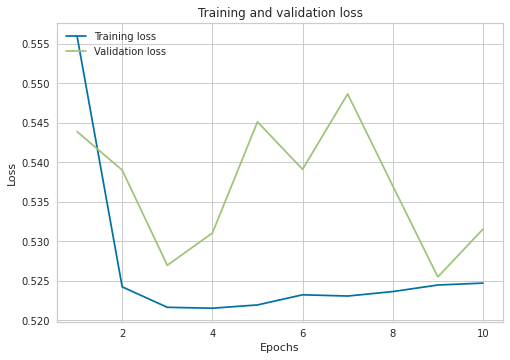

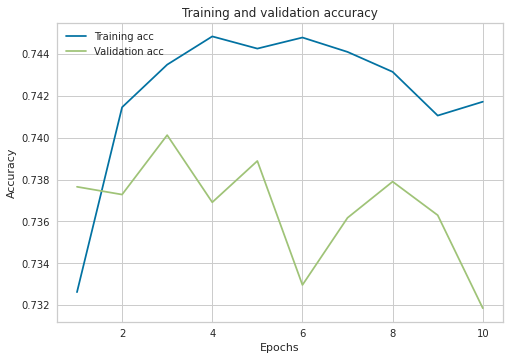

In [31]:
plot_loss(history)
plot_accuracy(history)